In [96]:
import numpy as np
import pandas as pd
from scipy.special import comb
import matplotlib.pyplot as plt

champion_data = pd.read_csv('data/tftset6champions.csv')
rolling_probability_data = pd.read_json('data/rollprobability.json')
unit_pool_data = pd.read_json('data/unitpool.json', typ='series')

np.set_printoptions(precision=6, linewidth=110)

In [97]:
UNIT_MAX = None
POOL_MAX = None
P_N_COST = None
DIST_N_COST = None

def config_rolldown(level, n_cost):
    global UNIT_MAX, POOL_MAX, P_N_COST, DIST_N_COST
    UNIT_MAX = unit_pool_data[n_cost]
    POOL_MAX = UNIT_MAX * champion_data[champion_data['cost'] == n_cost]['cost'].size
    P_N_COST = rolling_probability_data[level][n_cost - 1]
    DIST_N_COST = binary_dist(5, P_N_COST)
    
def binary_dist(n, p):
    prob_density = np.zeros(n + 1)
    for k in range(n + 1):
        prob_density[k] = comb(n, k) * np.power(p, k) * np.power(1 - p, n - k)
    return prob_density

# row is number of unit pulled from bag, column is number of hits
def bag_dist(n, pool, unit):
    prob_density = np.zeros((n + 1, n + 1))
    for i in range(prob_density.shape[0]):
        for j in range(prob_density.shape[1]):
            prob_density[i][j] = comb(unit, j) * comb(pool - unit, i - j) / comb(pool, i)
    return prob_density

def roll_node_naive(current, current_contested=None, current_uncontested=None):
    bag_dist_array = bag_dist(5, POOL_MAX - current, UNIT_MAX - current)
    hit_dist_array = np.matmul(DIST_N_COST, bag_dist_array)
    return hit_dist_array

level = 8
n_cost = 4
config_rolldown(level, n_cost)
for current in np.arange(9):
    roll_node_dist = roll_node_naive(current)
    print(current, roll_node_dist, np.sum(roll_node_dist))


0 [8.910437e-01 1.043664e-01 4.500519e-03 8.857428e-05 7.876418e-07 2.500450e-09] 0.9999999999999999
1 [8.990053e-01 9.709689e-02 3.829041e-03 6.822744e-05 5.425189e-07 1.516021e-09] 1.0
2 [9.071483e-01 8.960123e-02 3.199134e-03 5.097368e-05 3.567900e-07 8.597349e-10] 1.0
3 [9.154787e-01 8.187049e-02 2.613968e-03 3.666356e-05 2.212958e-07 4.470621e-10] 0.9999999999999999
4 [9.240025e-01 7.389528e-02 2.076923e-03 2.512100e-05 1.271243e-07 2.067061e-10] 0.9999999999999999
5 [9.327264e-01 6.566575e-02 1.591603e-03 1.614042e-05 6.574264e-08 8.066581e-11] 1.0000000000000002
6 [9.416571e-01 5.717154e-02 1.161850e-03 9.483774e-06 2.915021e-08 2.399194e-11] 0.9999999999999998
7 [9.508015e-01 4.840181e-02 7.917599e-04 4.877123e-06 1.005580e-08 4.163890e-12] 1.0
8 [9.601671e-01 3.934514e-02 4.857053e-04 2.006995e-06 2.081945e-09 0.000000e+00] 1.0


In [98]:
def roll_node_improved(current, current_contested, current_uncontested):
    bag_dist_array = bag_dist(5, POOL_MAX - current - current_contested - current_uncontested, UNIT_MAX - current - current_contested)
    hit_dist_array = np.matmul(DIST_N_COST, bag_dist_array)
    return hit_dist_array

level = 8
n_cost = 4
config_rolldown(level, n_cost)
print("UNCONTESTED")
for current in np.arange(9):
    roll_node_dist = roll_node_improved(current, 0, 27)
    print(current, roll_node_dist, np.sum(roll_node_dist))
print("CONTESTED")
for current in np.arange(9):
    roll_node_dist = roll_node_improved(current, 3, 27)
    print(current, roll_node_dist, np.sum(roll_node_dist))

UNCONTESTED
0 [8.645164e-01 1.282893e-01 7.016883e-03 1.753626e-04 1.982441e-06 8.009863e-09] 1.0
1 [8.740663e-01 1.197946e-01 6.001674e-03 1.360165e-04 1.377196e-06 4.906041e-09] 1.0
2 [8.838898e-01 1.109654e-01 5.041557e-03 1.023388e-04 9.136318e-07 2.811175e-09] 0.9999999999999999
3 [8.939981e-01 1.017850e-01 4.142219e-03 7.413983e-05 5.717155e-07 1.477301e-09] 0.9999999999999998
4 [9.044033e-01 9.223539e-02 3.309833e-03 5.117274e-05 3.314028e-07 6.904225e-10] 1.0
5 [9.151179e-01 8.229773e-02 2.551097e-03 3.312574e-05 1.729697e-07 2.723933e-10] 1.0
6 [9.261552e-01 7.195185e-02 1.873286e-03 1.961313e-05 7.741703e-08 8.192278e-11] 1.0
7 [9.375292e-01 6.117630e-02 1.284302e-03 1.016512e-05 2.696262e-08 1.438006e-11] 1.0
8 [9.492548e-01 4.994826e-02 7.927292e-04 4.216465e-06 5.636985e-09 0.000000e+00] 1.0
CONTESTED
0 [8.939981e-01 1.017850e-01 4.142219e-03 7.413983e-05 5.717155e-07 1.477301e-09] 0.9999999999999998
1 [9.044033e-01 9.223539e-02 3.309833e-03 5.117274e-05 3.314028e-07 6.904

In [99]:
def generate_markov_chain(current, current_contested, current_uncontested, roll_node_func):
    stochastic = np.zeros((10, 10))
    for i in np.arange(10):
        roll = roll_node_func(i, current_contested, current_uncontested)
        if i + 6 <= 10:
            stochastic[i][i:i+6] = roll
        else:
            over = i - (len(stochastic) - len(roll))
            roll[len(roll) - over - 1] += np.sum(roll[len(roll) - over:])
            stochastic[i][i:i+6-over] = roll[0:6-over]
    return stochastic

def generate_starting_units(n):
    assert n >= 0 and n <= 9
    return np.concatenate((np.zeros(n), np.ones(1), np.zeros(9 - n)), axis=None)
    
start = generate_starting_units(0)
stochastic = generate_markov_chain(0, 0, 27, roll_node_improved)
current_stochastic = np.identity(10)
for i in range(1, 50):
    print("ROLL " + str(i) + ":", np.matmul(start, current_stochastic))
    current_stochastic = np.matmul(current_stochastic, stochastic)

ROLL 1: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ROLL 2: [8.645164e-01 1.282893e-01 7.016883e-03 1.753626e-04 1.982441e-06 8.009863e-09 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00]
ROLL 3: [7.473887e-01 2.230416e-01 2.763673e-02 1.856960e-03 7.418153e-05 1.818275e-06 2.726234e-08 2.418641e-10
 1.181382e-12 2.756367e-15]
ROLL 4: [6.461298e-01 2.908351e-01 5.639134e-02 6.196527e-03 4.272517e-04 1.933950e-05 5.844363e-07 1.176234e-08
 1.545469e-10 1.278828e-12]
ROLL 5: [5.585898e-01 3.371008e-01 8.921803e-02 1.365598e-02 1.342261e-03 8.894976e-05 4.059365e-06 1.279806e-07
 2.752480e-09 3.950094e-11]
ROLL 6: [4.829101e-01 3.663095e-01 1.231613e-01 2.422966e-02 3.100674e-03 2.713687e-04 1.661824e-05 7.157292e-07
 2.145807e-08 4.411142e-10]
ROLL 7: [4.174837e-01 3.821310e-01 1.561315e-01 3.761107e-02 5.942181e-03 6.478033e-04 4.989752e-05 2.731887e-06
 1.053382e-07 2.832892e-09]
ROLL 8: [3.609215e-01 3.875666e-01 1.867097e-01 5.331606e-02 1.004232e-02 1.313197e-03 1.221262e-04 8.130072e-06
 

In [100]:
start = generate_starting_units(6)
stochastic = generate_markov_chain(0, 0, 27, roll_node_improved)
current_stochastic = np.identity(10)
for i in range(50):
    print("ROLL " + str(i) + ":", np.matmul(start, current_stochastic))
    current_stochastic = np.matmul(current_stochastic, stochastic)

ROLL 0: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
ROLL 1: [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.261552e-01 7.195185e-02
 1.873286e-03 1.969063e-05]
ROLL 2: [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 8.577634e-01 1.340955e-01
 7.914929e-03 2.261288e-04]
ROLL 3: [0.       0.       0.       0.       0.       0.       0.794422 0.187436 0.017324 0.000818]
ROLL 4: [0.       0.       0.       0.       0.       0.       0.735758 0.232887 0.029399 0.001956]
ROLL 5: [0.       0.       0.       0.       0.       0.       0.681426 0.271278 0.043533 0.003763]
ROLL 6: [0.       0.       0.       0.       0.       0.       0.631106 0.30336  0.059196 0.006337]
ROLL 7: [0.       0.       0.       0.       0.       0.       0.584502 0.329819 0.075933 0.009746]
ROLL 8: [0.       0.       0.       0.       0.       0.       0.54134  0.351271 0.093352 0.014038]
ROLL 9: [0.       0.       0.       0.       0.       0.       0.501365 0.3682

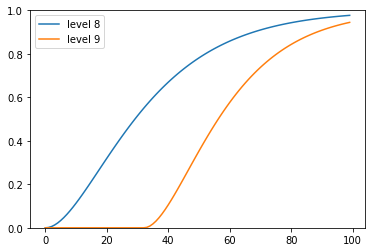

In [131]:
def model_rolldown(level, n_cost, starting_units_num, current_contested, current_uncontested, n_rolls):
    config_rolldown(level, n_cost)
    start = generate_starting_units(starting_units_num)
    stochastic = generate_markov_chain(0, current_contested, current_uncontested, roll_node_improved)
    current_stochastic = np.identity(10)
    rolldown_prob = np.zeros(n_rolls)
    for i in range(n_rolls):
        rolldown_prob[i] = np.matmul(start, current_stochastic)[len(current_stochastic) - 1]
        current_stochastic = np.matmul(current_stochastic, stochastic)
    return rolldown_prob
    
n_cost = 4
starting_units_num = 7
current_contested = 0
current_uncontested = 27
n_rolls = 100
level_to_9_offset = 32 # 64 gold to level
level8_rolldown_prob = model_rolldown(8, n_cost, starting_units_num, current_contested, current_uncontested, n_rolls)
level9_rolldown_prob = model_rolldown(9, n_cost, starting_units_num, current_contested, current_uncontested, n_rolls)
plt.plot(np.arange(n_rolls), level8_rolldown_prob, label="level 8")
plt.plot(np.arange(n_rolls), np.concatenate((np.zeros(level_to_9_offset), level9_rolldown_prob[:(n_rolls - level_to_9_offset)]), axis=None), label="level 9")
plt.legend()
a = plt.ylim(0, 1)

